In [130]:
using DataFrames, CSV, Plots,Statistics, StatsPlots, Distributions, StatsBase, StatsModels, HypothesisTests, LinearAlgebra, StateSpaceModels, Optim, Plots

In [138]:
gr(size=(1200,450))

Plots.GRBackend()

In [139]:
cd("/Users/ning/Library/Mobile Documents/com~apple~CloudDocs/Working_Directory/Tex_MD/Teaching/tutorial/6003/W6")

In [140]:
df = CSV.read("AuQuGDP.csv", DataFrame);

In [141]:
first(df, 5)

,Time,AuGDP,quarter,year,t
,String15,Float64,Int64,Int64,String7
1,01jan1960,6.4683e10,1,1960,1960q1
2,01apr1960,6.6473e10,2,1960,1960q2
3,01jul1960,6.6623e10,3,1960,1960q3
4,01oct1960,6.649e10,4,1960,1960q4
5,01jan1961,6.669e10,1,1961,1961q1


In [142]:
function ac_pac(data)

    plot(xlabel="t", legend=false)
    display(plot!(data, color="orangered"))

    acf_gdp  = autocor(data);
    acf2_gdp = acf_gdp.^2;
    pacf_gdp = pacf(data,[1:1:21;]);

    se_acf_gdp = []

    for i in [1:size(acf_gdp)[1];]  
        push!(se_acf_gdp, sqrt((1+2*sum(acf2_gdp[1:i-1]))/size(data)[1]));   
    end

    ub_acf_gdp = se_acf_gdp * quantile(TDist(size(data)[1]-1), 0.975);
    lb_acf_gdp = se_acf_gdp * quantile(TDist(size(data)[1]-1), 0.025);

    ub_pacf_gdp = quantile(TDist(size(data)[1]-1), 0.975) / sqrt(size(data)[1]);
    lb_pacf_gdp = quantile(TDist(size(data)[1]-1), 0.025) / sqrt(size(data)[1]);

    p1 = bar(acf_gdp, title = "ACF", c = "red", legend = :topright, bar_width = 0.2)
    p1 = plot!(zeros(size(acf_gdp)[1]), ribbon = (ub_acf_gdp .- lb_acf_gdp)./2 , fillalpha = 0.35, c = 1, lw = 2)

    p2 = bar(pacf_gdp, title = "PACF", c = "red", legend = false, bar_width = 0.2)
    p2 = plot!(zeros(size(acf_gdp)[1]), ribbon = (ub_pacf_gdp .- lb_pacf_gdp)./2 , fillalpha = 0.35, c = 1, lw = 2)

    display(plot(p1, p2, layout = (2, 1), legend = false))

    ADFTest(data, Symbol("trend"), 3)

end


ac_pac (generic function with 1 method)

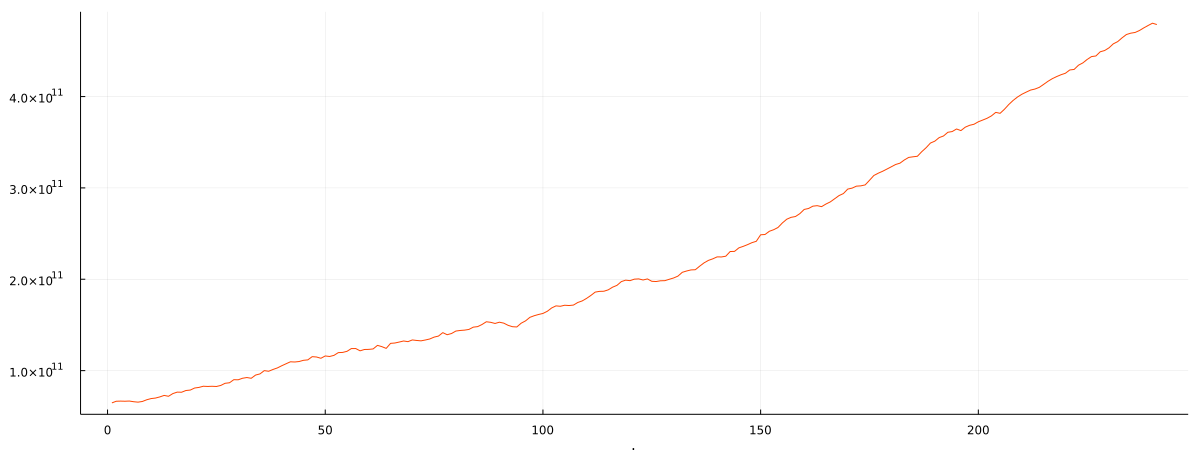

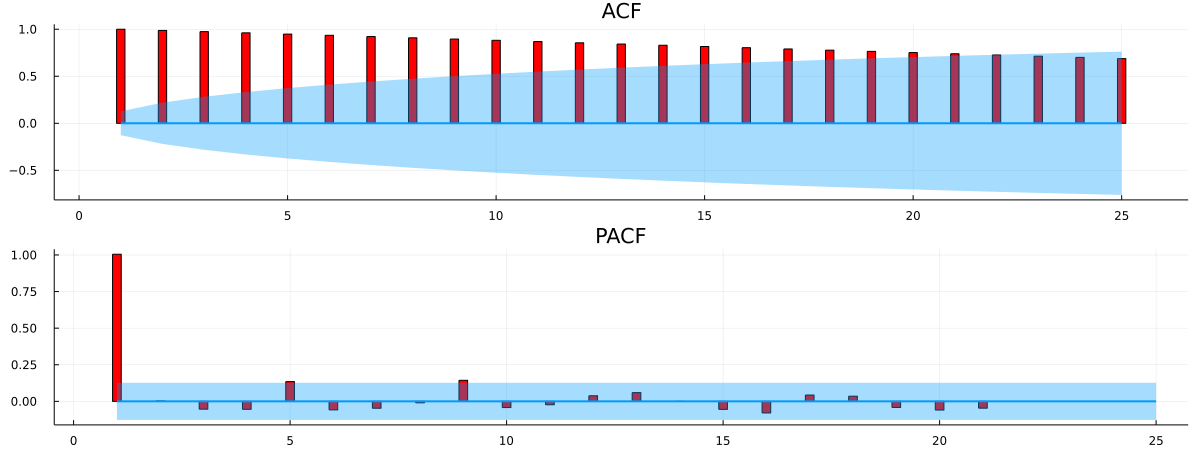

Augmented Dickey-Fuller unit root test
--------------------------------------
Population details:
    parameter of interest:   coefficient on lagged non-differenced variable
    value under h_0:         0
    point estimate:          -0.00187636

Test summary:
    outcome with 95% confidence: fail to reject h_0
    p-value:                     0.9855

Details:
    sample size in regression:          237
    number of lags:                     3
    ADF statistic:                      -0.443589
    Critical values at 1%, 5%, and 10%: [-3.99683 -3.42887 -3.13785]


In [143]:
ac_pac(df.AuGDP)

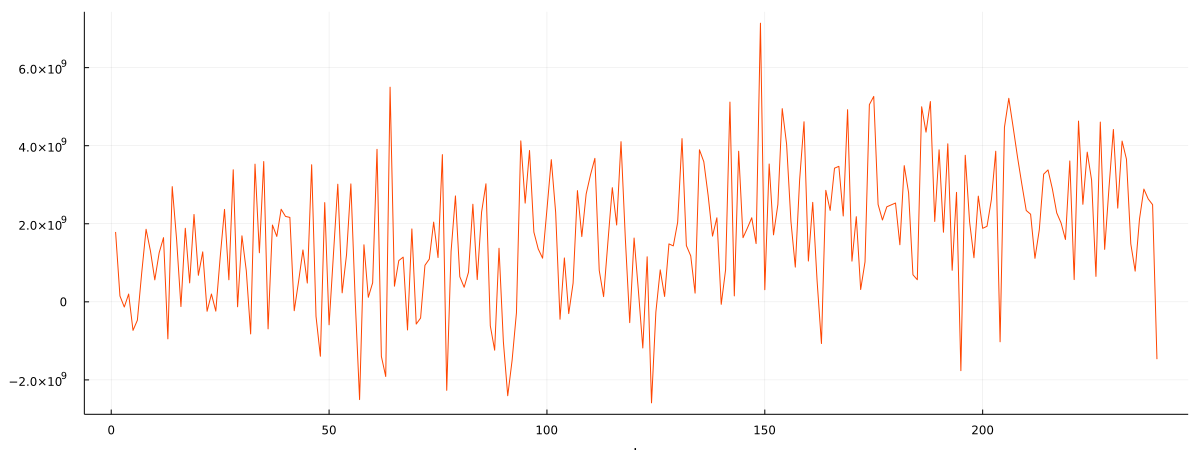

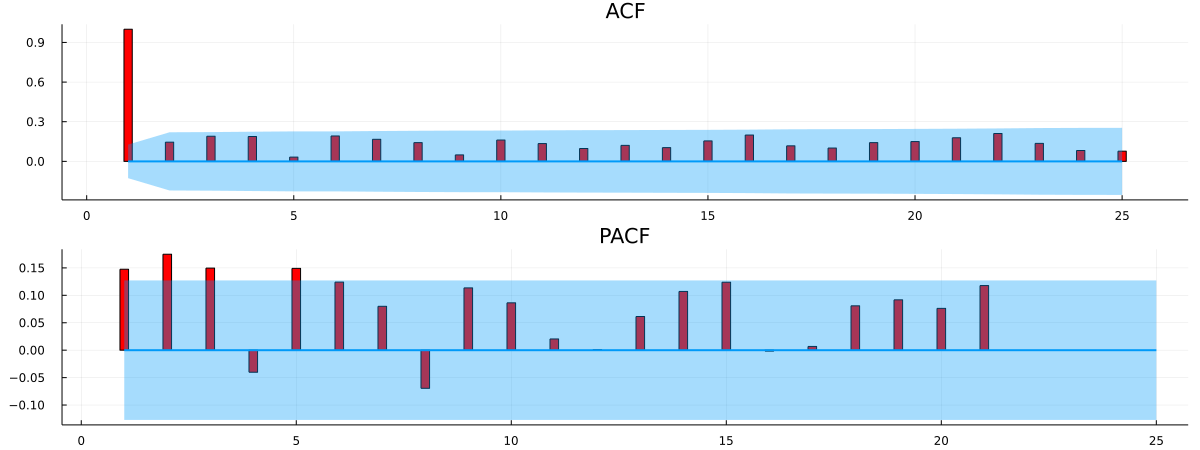

Augmented Dickey-Fuller unit root test
--------------------------------------
Population details:
    parameter of interest:   coefficient on lagged non-differenced variable
    value under h_0:         0
    point estimate:          -1.03424

Test summary:
    outcome with 95% confidence: reject h_0
    p-value:                     <1e-10

Details:
    sample size in regression:          236
    number of lags:                     3
    ADF statistic:                      -8.02704
    Critical values at 1%, 5%, and 10%: [-3.99699 -3.42894 -3.13789]


In [144]:
s_D1 = diff(df.AuGDP)
ac_pac(s_D1)

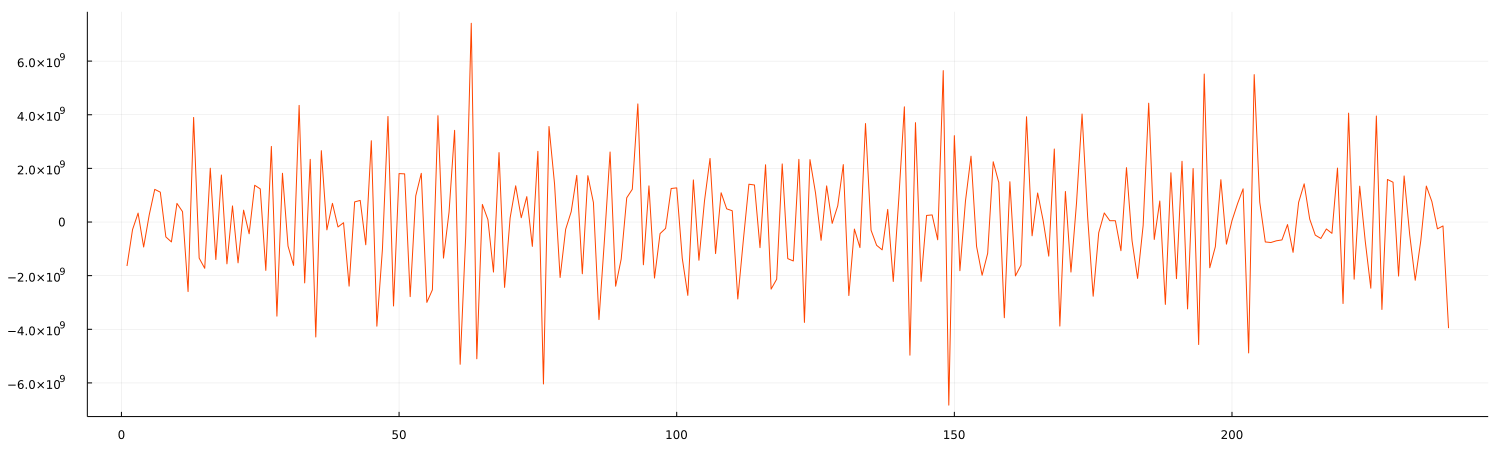

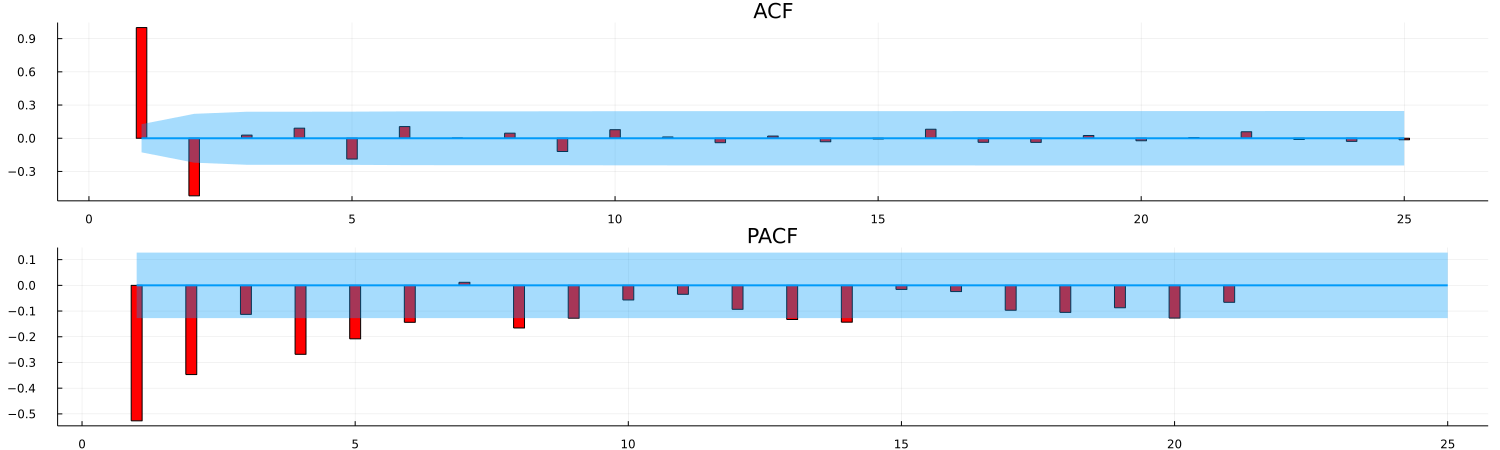

Augmented Dickey-Fuller unit root test
--------------------------------------
Population details:
    parameter of interest:   coefficient on lagged non-differenced variable
    value under h_0:         0
    point estimate:          -2.91378

Test summary:
    outcome with 95% confidence: reject h_0
    p-value:                     <1e-19

Details:
    sample size in regression:          235
    number of lags:                     3
    ADF statistic:                      -13.0219
    Critical values at 1%, 5%, and 10%: [-3.99716 -3.42902 -3.13794]


In [44]:
s_D2 = diff(s_D1)
ac_pac(s_D2)

In [76]:
data = df.AuGDP[1:235];

M1 = SARIMA(data; order = (7, 1, 7), seasonal_order = (0, 0, 0, 0));
StateSpaceModels.fit!(M1);

┌ Warning: Conditional sum of squares estimated initial_ar out of the unit circle, using zero as starting params
└ @ StateSpaceModels /Users/ning/.julia/packages/StateSpaceModels/GwVUY/src/models/sarima.jl:587
┌ Warning: Conditional sum of squares estimated initial_ma out of the unit circle, using zero as starting params
└ @ StateSpaceModels /Users/ning/.julia/packages/StateSpaceModels/GwVUY/src/models/sarima.jl:591


In [59]:
results(M1)

                             Results                           
Model:                        SARIMA(7, 1, 7)x(0, 0, 0, 0) with zero mean    
Number of observations:       235
Number of unknown parameters: 15
Log-likelihood:               -5302.4994
AIC:                          1.063E+04
AICc:                         1.064E+04
BIC:                          1.069E+04
---------------------------------------------------------------
Parameter      Estimate      Std.Error      z stat      p-value
ar_L1           -1.1036     -1007.2804      0.0011           - 
ar_L2           -0.7678        -2.4410      0.3145           - 
ar_L3           -0.2317         0.1477     -1.5683       0.0000
ar_L4            0.2475        -0.3627     -0.6826           - 
ar_L5            0.7793         6.5561      0.1189       0.9198
ar_L6            1.1101        -8.5961     -0.1291           - 
ar_L7            0.9661       313.5365      0.0031       0.9975
ma_L1            1.1070      -110.6983     -0.0100    

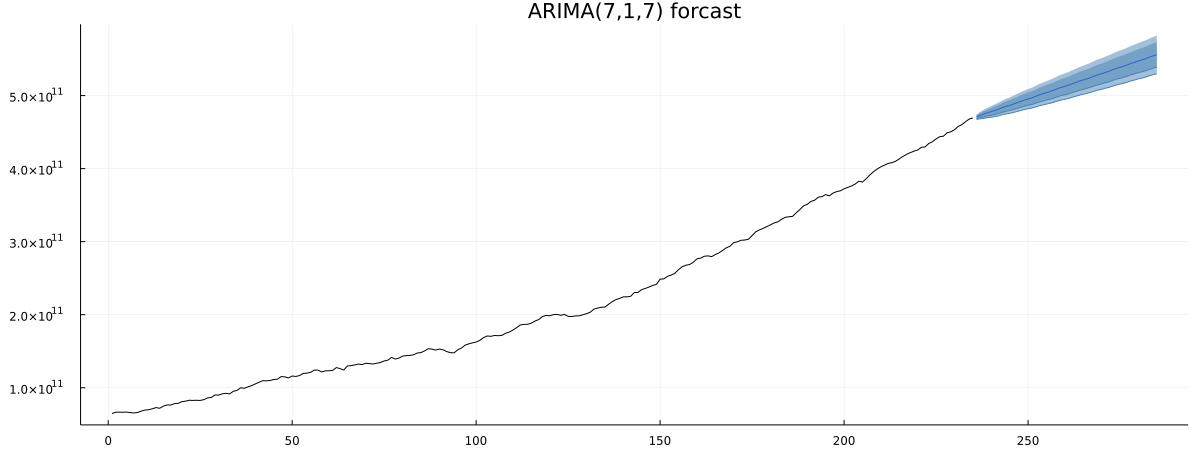

In [145]:
M1_forcast = forecast(M1, 50);
plot(M1, M1_forcast; title = "ARIMA(7,1,7) forcast", label = "")

In [151]:
M2 = auto_arima(data, max_p=7, max_q=7, show_trace=true);
StateSpaceModels.fit!(M2);

Model specification                               Selection metric
SARIMA(2, 2, 2)x(0, 0, 0, 0) with zero mean     : 10657.558602970616
SARIMA(0, 2, 0)x(0, 0, 0, 0) with zero mean     : 10700.150936357371
SARIMA(1, 2, 0)x(0, 0, 0, 0) with zero mean     : 10691.63380157832
SARIMA(0, 2, 1)x(0, 0, 0, 0) with zero mean     : 10688.330969583989
Search iteration complete: Current best is SARIMA(2, 2, 2)x(0, 0, 0, 0) with zero mean    
SARIMA(2, 2, 2)x(0, 0, 0, 0) with zero mean     : 10657.558602970616
SARIMA(1, 2, 1)x(0, 0, 0, 0) with zero mean     : 10653.881114575277
SARIMA(1, 2, 2)x(0, 0, 0, 0) with zero mean     : 10654.919812622935
SARIMA(1, 2, 3)x(0, 0, 0, 0) with zero mean     : 10656.636752219052
SARIMA(2, 2, 1)x(0, 0, 0, 0) with zero mean     : 10654.823952500714
SARIMA(2, 2, 3)x(0, 0, 0, 0) with zero mean     : 10659.079949187511
SARIMA(3, 2, 1)x(0, 0, 0, 0) with zero mean     : 10656.238067034594
SARIMA(3, 2, 2)x(0, 0, 0, 0) with zero mean     : 10658.98807322373
Search iteration

In [152]:
results(M2)

                             Results                           
Model:                        SARIMA(1, 2, 1)x(0, 0, 0, 0) with zero mean    
Number of observations:       235
Number of unknown parameters: 3
Log-likelihood:               -5323.8886
AIC:                          1.065E+04
AICc:                         1.065E+04
BIC:                          1.066E+04
---------------------------------------------------------------
Parameter      Estimate      Std.Error      z stat      p-value
ar_L1            0.6021         2.4318      0.2476       0.8841
ma_L1           -0.9828      4065.1685     -0.0002       0.9998
sigma2_η      5.126E+18         0.0000   2.083E+32       0.0000


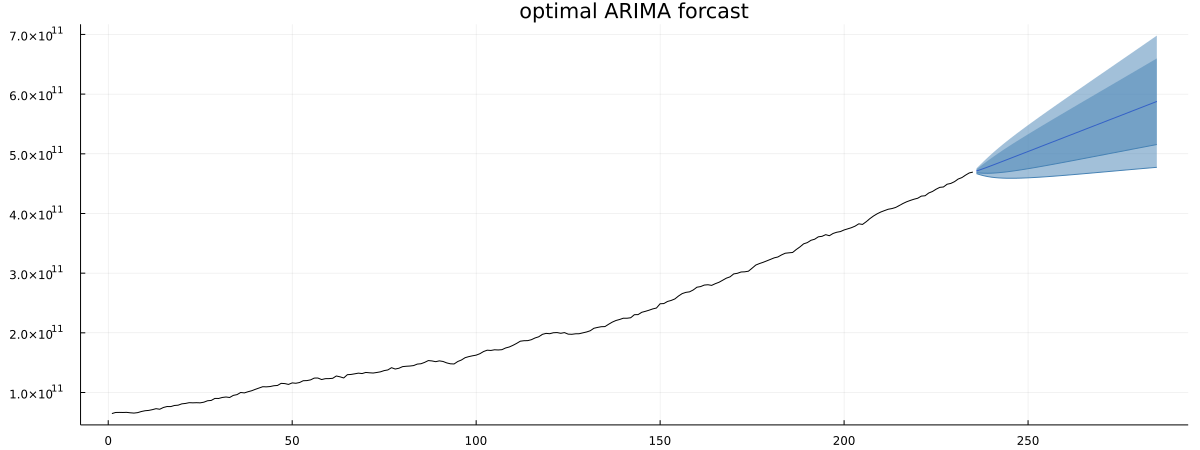

In [153]:
M2_forcast = forecast(M2, 50);
plot(M2, M2_forcast; title = "optimal ARIMA forcast", label = "")

In [155]:
run(`rm -rf W5_Julia.html`)
run(`jupyter nbconvert --to html W5_Julia.ipynb`)

[NbConvertApp] Converting notebook W5_Julia.ipynb to html
[NbConvertApp] Writing 1021813 bytes to W5_Julia.html


Process(`jupyter nbconvert --to html W5_Julia.ipynb`, ProcessExited(0))